# Download the Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook

In [ ]:
PATH_TO_IMAGE = "/content/drive/My Drive/CS 419/perfectly_painted_cat.png"

Image height= 400 px, and width= 400 px and data type: uint8


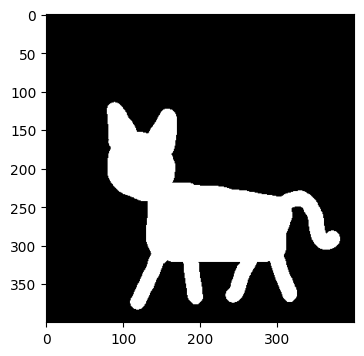

In [ ]:
input=cv2.imread(PATH_TO_IMAGE,cv2.IMREAD_GRAYSCALE)
# pring image properties
height, width = input.shape
print("Image height=", height, "px, and width=", width, "px and data type:", input.dtype)

plt.figure(figsize=(4, 4))  # Adjust the width and height as needed
plt.imshow(input, cmap='gray')
# Show the plot
plt.show()

In [ ]:
#deep copy
black_n_white_img = input.copy()

In [ ]:
def convert_to_binary(input):
  matrix = []
  for i in range(len(input)):
    list_of_bins = []
    for j in range(len(input[0])):
      if input[i][j] == 255:
        list_of_bins.append(1)
      else:
        list_of_bins.append(0)
    matrix.append(list_of_bins)
  return np.array(matrix)

binary_image = convert_to_binary(black_n_white_img)

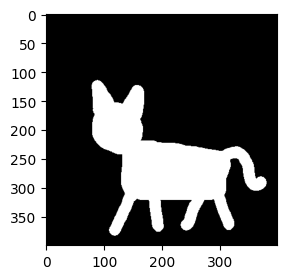

In [ ]:
plt.figure(figsize=(3, 3))  # Adjust the width and height as needed
plt.imshow(binary_image, cmap='gray')
# Show the plot
plt.show()

# Erosion

In [ ]:
#Structring Elements

B1 = np.array([[1 , 0 , 0],
               [1 , -1 , 0],
               [1 , 0 , 0]])

B2 = np.array([[1 , 1 , 1],
               [0 , -1 , 0],
               [0 , 0 , 0]])

B3 = np.array([[0 , 0 , 1],
               [0 , -1 , 1],
               [0 , 0 , 1]])

B4 = np.array([[0 , 0 , 0],
               [0 , -1 , 0],
               [1 , 1 , 1]])

Background_SE = np.array([[0 , 0 , 0],
                          [0 , 1 , 0],
                          [0 , 0 , 0]])

se_list = [B1,B2,B3,B4]

In [ ]:
def erode_image(image, kernel):

  eroded_image = np.zeros_like(image)

  i_height, i_width = image.shape[0], image.shape[1]
  k_height, k_width = kernel.shape[0], kernel.shape[1]

  for y in range(image.shape[0] - kernel.shape[0] + 1):   #for each row
    for x in range(image.shape[1] - kernel.shape[1] + 1): #for each column
      interested_region = image[y:y+k_height, x:x+k_width]

      is_fit = True

      for i in range(len(interested_region)):
        for j in range(len(interested_region[0])):
          if kernel[i][j] == 1 and interested_region[i][j] == 0:
            is_fit = False


      if is_fit:
            eroded_image[y+1, x+1] = 1

  return eroded_image

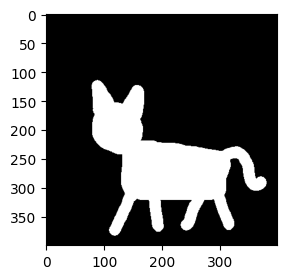

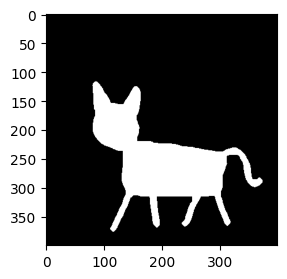

In [ ]:
eroded_image = erode_image(binary_image, np.ones((8,8)))

#Non Eroded Image
plt.figure(figsize=(3, 3))  # Adjust the width and height as needed
plt.imshow(binary_image, cmap='gray')
# Show the plot
plt.show()

#Eroded Image
plt.figure(figsize=(3, 3))  # Adjust the width and height as needed
plt.imshow(eroded_image, cmap='gray')
# Show the plot
plt.show()

#### (A - B1) n (A^c - B2)

# Hit or Miss

In [ ]:
def get_intersection(source1, source2):
  intersection = np.zeros_like(source1)
  count = 0
  for i in range(len(source1)):
    for j in range(len(source1[0])):
      if source1[i][j] == 1 and source2[i][j] == 1:
        intersection[i][j] = 1
        count += 1
  #print("Intersection count: ", count)
  return intersection

In [ ]:
def get_complement(source):
  complement = np.zeros_like(source)
  for i in range(len(source)):
    for j in range(len(source[0])):
      if(source[i][j] == 0):
        complement[i][j] = 1
  return complement

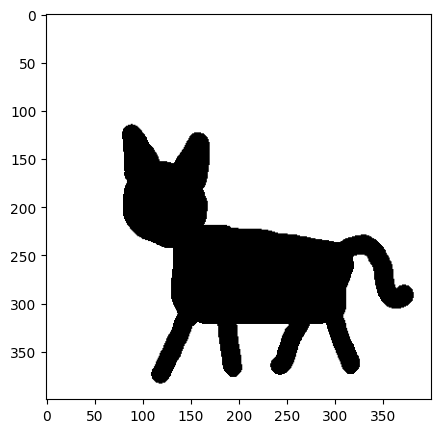

In [ ]:
image_complement = get_complement(binary_image)
#Eroded Image
plt.figure(figsize=(5, 5))  # Adjust the width and height as needed
plt.imshow(image_complement, cmap='gray')
# Show the plot
plt.show()

In [ ]:
def hit_or_miss(image, kernel, bg = Background_SE):

  B1 = kernel.copy()
  B2 = bg

  image_complement = get_complement(image)

  A1 = erode_image(image, B1)
  A2 = erode_image(image_complement, B2)

  intersection = get_intersection(A1,A2)

  return intersection

In [ ]:
hit_miss_list = []

for se in se_list:
  hit_miss_list.append(hit_or_miss(binary_image, se))


Intersection count:  306
Intersection count:  163
Intersection count:  320
Intersection count:  181


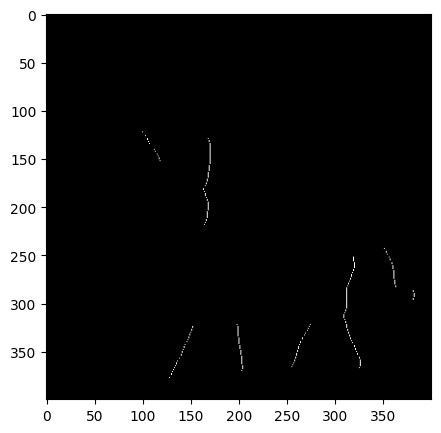

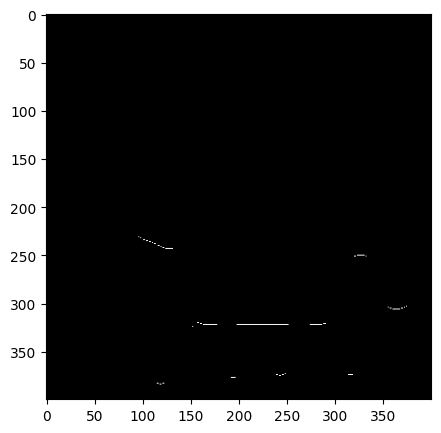

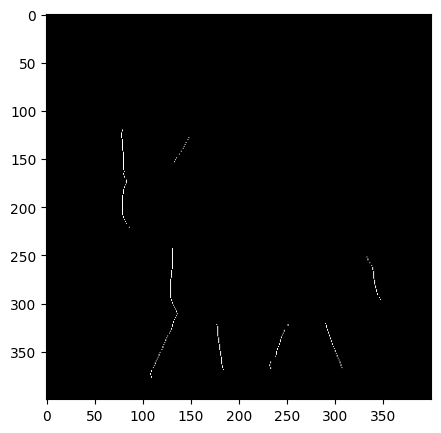

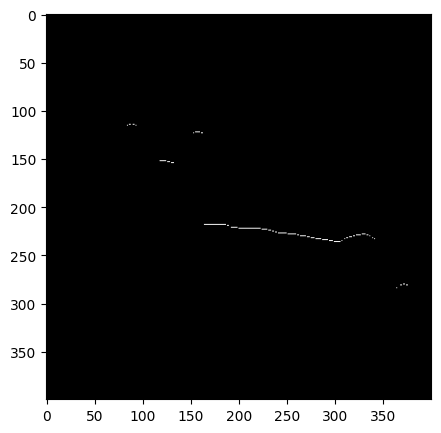

In [ ]:
for h_m in hit_miss_list:
  #Eroded Image
  plt.figure(figsize=(5, 5))  # Adjust the width and height as needed
  plt.imshow(h_m, cmap='gray')
  # Show the plot
  plt.show()

# Thickening

In [ ]:
def get_union(s1, s2):
  Union = np.zeros_like(s1)
  count = 0
  for i in range(len(s1)):
    for j in range(len(s1[0])):
      if s1[i][j] == 1 or s2[i][j] == 1:
        Union[i][j] = 1
        count += 1
  #print("Union count: ", count)
  return Union

In [ ]:
def thickening(img, se):

  h_o_m = hit_or_miss(img, se)
  union = get_union(img, h_o_m)

  return union


# Convex Hull

In [ ]:
def convex_hull(img, se_list):

  thickening_union_arr = []
  main_img = img.copy()

  for _se in se_list:

    stack = list()
    stack.append(main_img)

    while(len(stack) > 0):
      img = stack.pop()
      thick = thickening(img, _se)
      if not np.array_equal(img ,thick):
        stack.append(thick)

    thickening_union_arr.append(thick)

  u1 = get_union(thickening_union_arr[0], thickening_union_arr[1])
  u2 = get_union(u1, thickening_union_arr[2])
  u3 = get_union(u2, thickening_union_arr[3])

  return u3

In [ ]:
ch = convex_hull(binary_image, se_list)

In [ ]:
def optimize_the_limits(img, ch):

  min_y = float('inf')
  max_y = -1
  min_x = float('inf')
  max_x = -1

  limited_ch = ch.copy()

  for y in range(len(img)):
    for x in range(len(img[0])):
      if img[y][x] == 1:
        if y < min_y:
          min_y = y

        if y > max_y:
          max_y = y

        if x < min_x:
          min_x = x

        if x > max_x:
          max_x = x

  print(f"max x, y: {max_x}, {max_y}    min x, y: {min_x}, {min_y}")

  #cut the limits
  for y in range(len(img)):
    for x in range(len(img[0])):

      if( min_x > x or max_x < x ):
        limited_ch[y][x] = 0
      if( min_y > y or max_y < y ):
        limited_ch[y][x] = 0

  return limited_ch

cutted_image = optimize_the_limits(binary_image, ch)

max x, y: 381, 383    min x, y: 79, 114


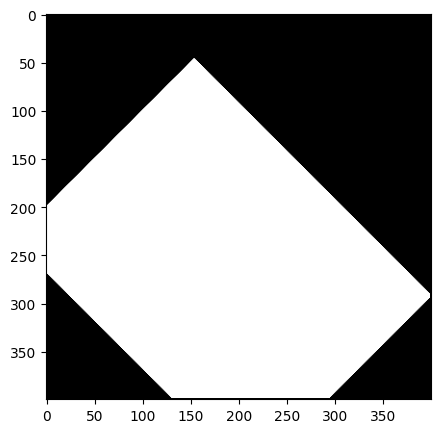

In [ ]:
#Eroded Image
plt.figure(figsize=(5, 5))  # Adjust the width and height as needed
plt.imshow(ch, cmap='gray')
# Show the plot
plt.show()

# Final Output

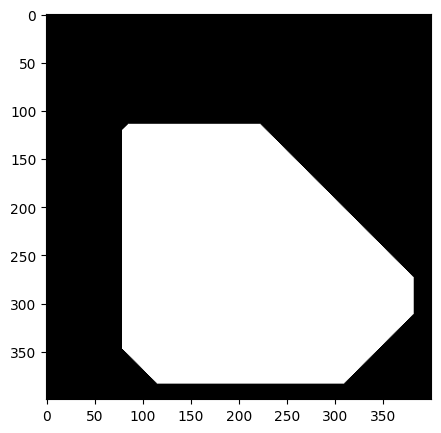

In [ ]:
#Eroded Image
plt.figure(figsize=(5, 5))  # Adjust the width and height as needed
plt.imshow(cutted_image, cmap='gray')
# Show the plot
plt.show()